# Здесь описать цели работы, гипотезу и идеи

In [93]:
import requests
import json
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# plots to png
save_plots_to_file = True
# plots style
sns.set_style()
sns.set_theme()
plt.style.use("dark_background")


# data have many ';' and ','
csv_delimiter = "::"
# indicators to analysis
indicators = [
    "NY.GDP.MKTP.CD",  # GDP (current $)
    "NY.GDP.PCAP.KD",  # GDP per capita (constant 2015 $)
    "FP.CPI.TOTL.ZG",  # Inflation, consumer prices (annual %)
    "SL.UEM.TOTL.ZS",  # Unemployment, total (% of total labor force) (modeled ILO estimate)
    "TX.VAL.TECH.CD",  # High-technology exports (current US$)
    "SE.TER.CUAT.BA.ZS",  # Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)
    "TX.VAL.MMTL.ZS.UN",  # Ores and metals exports (% of merchandise exports)
    "TX.VAL.FUEL.ZS.UN",  # Fuel exports (% of merchandise exports)
    "SE.XPD.TOTL.GB.ZS",  # Government expenditure on education, total (% of government expenditure)
    "NY.GNP.PCAP.CD",  # GNI per capita, Atlas method (current US$)
    "SP.POP.GROW",  # Population growth (annual %)
    "SP.DYN.LE00.IN",  # Life expectancy at birth, total (years)
    "SP.DYN.CBRT.IN",  # Birth rate, crude (per 1,000 people)
    "SP.DYN.CDRT.IN",  # Death rate
    "SH.STA.SUIC.P5",  # Suicide mortality rate (per 100,000 population)
    "BM.GSR.MRCH.CD",  # Goods imports (BoP, current US$)
    "BM.GSR.NFSV.CD",  # Service imports (BoP, current US$)
    "BX.GSR.MRCH.CD",  # Goods exports (BoP, current US$)
    "BX.GSR.NFSV.CD",  # Service exports (BoP, current US$)
    "NE.IMP.GNFS.CD",  # Imports of goods and services (current US$)
    "NE.EXP.GNFS.CD",  # Exports of goods and services (current US$)
    "SP.POP.TOTL",  # Population, total
]


def download_json(url: str, filepath: str):
    """Download json from url and return result"""
    dataset_request = requests.get(
        url,
        stream=True,
    )
    # write bytes to file
    with open(filepath, "wb") as file:
        for chunk in dataset_request.iter_content(chunk_size=128):
            file.write(chunk)
    # read downloaded json
    with open(filepath, "rt") as file:
        res = json.load(file)
    return res


def download_indicators_list():
    """Get full list of indicators from specified datasets and write to inticators.csv"""
    datasets_ids = [
        "0037712",  # World Development Indicators
        "0037798",  # Global Economical Monitor
    ]
    with open("indicators.csv", "wt") as indicators_file:
        print("name", "id", "load", sep=csv_delimiter, file=indicators_file)
        for dataset_unique_id in datasets_ids:
            # get dataset info
            dataset_url = f"https://datacatalogapi.worldbank.org/ddhxext/DatasetView?dataset_unique_id={dataset_unique_id}"
            dataset_metadata_path = f"datasets_metadata/{dataset_unique_id}.json"
            indicators = download_json(dataset_url, dataset_metadata_path)
            # get data for each indicator
            for indicator in indicators["Indicator"]:
                # parse url to get values
                name = indicator.split("::")[0]
                id = indicator.split("=")[-1]
                load = 0
                print(name, id, load, sep=csv_delimiter, file=indicators_file)


def get_indicators_data(indicators=None):
    """Download indicators from DataBank. If not specified based on settings from indicators.csv)"""
    all_indicators = pd.read_csv(
        "indicators.csv", delimiter=csv_delimiter, engine="python"
    )
    if indicators:
        needed_indicators = indicators
    else:
        needed_indicators = all_indicators[all_indicators["load"] == 1]["id"]
    df = pd.DataFrame(columns=["country", "date"])
    for id in needed_indicators:
        json_path = f"indicators/json/{id}.json"
        csv_path = f"indicators/csv/{id}.csv"
        # skip already loaded indicators
        if os.path.exists(csv_path):
            print(id, "is already loaded")
        else:
            url = f"https://api.worldbank.org/v2/country/all/indicator/{id}?per_page=20000&format=json"
            print("Downloading", id)
            data = download_json(url, json_path)
            # check if got valid data
            if len(data) != 2:
                print(f"Not found {id}")
                continue
            # convert raw json data to csv
            with open(csv_path, "wt") as csv_file:
                name = data[1][0]["indicator"]["value"]
                print("country", "date", name, sep=csv_delimiter, file=csv_file)
                for row in data[1]:
                    country = row["country"]["value"]
                    date = row["date"]
                    value = row["value"]
                    print(country, date, value, sep=csv_delimiter, file=csv_file)

        # read downloaded csv
        new = pd.read_csv(csv_path, delimiter=csv_delimiter, engine="python")
        # drop empty rows
        new.dropna(how="any", inplace=True)
        # merge with main dataset
        df = pd.merge(left=df, right=new, how="outer", on=("country", "date"))

    return df

In [94]:
# download_indicators_list()
raw_df = get_indicators_data(indicators)

NY.GDP.MKTP.CD is already loaded
NY.GDP.PCAP.KD is already loaded
FP.CPI.TOTL.ZG is already loaded
SL.UEM.TOTL.ZS is already loaded
TX.VAL.TECH.CD is already loaded
SE.TER.CUAT.BA.ZS is already loaded
TX.VAL.MMTL.ZS.UN is already loaded
TX.VAL.FUEL.ZS.UN is already loaded
SE.XPD.TOTL.GB.ZS is already loaded
NY.GNP.PCAP.CD is already loaded
SP.POP.GROW is already loaded
SP.DYN.LE00.IN is already loaded
SP.DYN.CBRT.IN is already loaded
SP.DYN.CDRT.IN is already loaded
SH.STA.SUIC.P5 is already loaded
BM.GSR.MRCH.CD is already loaded
BM.GSR.NFSV.CD is already loaded
BX.GSR.MRCH.CD is already loaded
BX.GSR.NFSV.CD is already loaded
NE.IMP.GNFS.CD is already loaded
NE.EXP.GNFS.CD is already loaded
SP.POP.TOTL is already loaded


In [95]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16930 entries, 0 to 16929
Data columns (total 24 columns):
 #   Column                                                                                             Non-Null Count  Dtype  
---  ------                                                                                             --------------  -----  
 0   country                                                                                            16930 non-null  object 
 1   date                                                                                               16930 non-null  int64  
 2   GDP (current US$)                                                                                  13979 non-null  float64
 3   GDP per capita (constant 2015 US$)                                                                 13963 non-null  float64
 4   Inflation, consumer prices (annual %)                                                              11004 non-null  flo

# Переименование столбцов

In [96]:
replace_rules = {
    "GDP (current US$)": "GDP",
    "GDP per capita (constant 2015 US$)": "GDP per capita",
    "Inflation, consumer prices (annual %)": "inflation",
    "Unemployment, total (% of total labor force) (modeled ILO estimate)": "unemployment",
    "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)": "educational attainment",
    "Government expenditure on education, total (% of government expenditure)": "education expenditure",
    "GNI per capita, Atlas method (current US$)": "GNI per capita",
    "Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)": "educational attainment",
    "Fertility rate, total (births per woman)": "fertility rate",
    "Population growth (annual %)": "population growth",
    "Life expectancy at birth, total (years)": "life expectancy",
    "Birth rate, crude (per 1,000 people)": "birth rate",
    "Death rate, crude (per 1,000 people)": "death rate",
    "Suicide mortality rate (per 100,000 population)": "suicide mortality rate",
    "Goods imports (BoP, current US$)": 'goods imports',
    "Service imports (BoP, current US$)": 'services imports',
    "Goods exports (BoP, current US$)": "goods exports",
    "Service exports (BoP, current US$)": 'services exports',
    "Imports of goods and services (current US$)": "total imports",
    "Exports of goods and services (current US$)": "total exports",
    "Population, total": "population"
}

for a, b in replace_rules.items():
    if a in raw_df.columns:
        raw_df[b] = raw_df[a]
        raw_df.drop(columns=[a], inplace=True)

In [97]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16930 entries, 0 to 16929
Data columns (total 24 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   country                                             16930 non-null  object 
 1   date                                                16930 non-null  int64  
 2   High-technology exports (current US$)               2771 non-null   float64
 3   Ores and metals exports (% of merchandise exports)  9457 non-null   float64
 4   Fuel exports (% of merchandise exports)             9141 non-null   float64
 5   GDP                                                 13979 non-null  float64
 6   GDP per capita                                      13963 non-null  float64
 7   inflation                                           11004 non-null  float64
 8   unemployment                                        7752 non-null   float64


# Отбор стран для анализа

In [98]:
# regions to take into statistics
# source data includes many regions (not counties)
# this is an array of countries

include_regions = np.array(
    [
        "Afghanistan",
        "Albania",
        "Algeria",
        "American Samoa",
        "Andorra",
        "Angola",
        "Antigua and Barbuda",
        "Argentina",
        "Armenia",
        "Aruba",
        "Australia",
        "Austria",
        "Azerbaijan",
        "Bahamas, The",
        "Bahrain",
        "Bangladesh",
        "Barbados",
        "Belarus",
        "Belgium",
        "Belize",
        "Benin",
        "Bermuda",
        "Bhutan",
        "Bolivia",
        "Bosnia and Herzegovina",
        "Botswana",
        "Brazil",
        "British Virgin Islands",
        "Brunei Darussalam",
        "Bulgaria",
        "Burkina Faso",
        "Burundi",
        "Cabo Verde",
        "Cambodia",
        "Cameroon",
        "Canada",
        "Cayman Islands",
        "Central African Republic",
        "Chad",
        "Channel Islands",
        "Chile",
        "China",
        "Colombia",
        "Comoros",
        "Congo, Dem. Rep.",
        "Congo, Rep.",
        "Costa Rica",
        "Cote d'Ivoire",
        "Croatia",
        "Cuba",
        "Curacao",
        "Cyprus",
        "Czechia",
        "Denmark",
        "Djibouti",
        "Dominica",
        "Dominican Republic",
        "Ecuador",
        "Egypt, Arab Rep.",
        "El Salvador",
        "Equatorial Guinea",
        "Eritrea",
        "Estonia",
        "Eswatini",
        "Ethiopia",
        "Faroe Islands",
        "Fiji",
        "Finland",
        "France",
        "French Polynesia",
        "Gabon",
        "Gambia, The",
        "Georgia",
        "Germany",
        "Ghana",
        "Gibraltar",
        "Greece",
        "Greenland",
        "Grenada",
        "Guam",
        "Guatemala",
        "Guinea",
        "Guinea-Bissau",
        "Guyana",
        "Haiti",
        "Honduras",
        "Hong Kong SAR, China",
        "Hungary",
        "Iceland",
        "India",
        "Indonesia",
        "Iran, Islamic Rep.",
        "Iraq",
        "Ireland",
        "Isle of Man",
        "Israel",
        "Italy",
        "Jamaica",
        "Japan",
        "Jordan",
        "Kazakhstan",
        "Kenya",
        "Kiribati",
        "Korea, Dem. People's Rep.",
        "Korea, Rep.",
        "Kosovo",
        "Kuwait",
        "Kyrgyz Republic",
        "Lao PDR",
        "Latvia",
        "Lebanon",
        "Lesotho",
        "Liberia",
        "Libya",
        "Liechtenstein",
        "Lithuania",
        "Luxembourg",
        "Macao SAR, China",
        "Madagascar",
        "Malawi",
        "Malaysia",
        "Maldives",
        "Mali",
        "Malta",
        "Marshall Islands",
        "Mauritania",
        "Mauritius",
        "Mexico",
        "Micronesia, Fed. Sts.",
        "Moldova",
        "Monaco",
        "Mongolia",
        "Montenegro",
        "Morocco",
        "Mozambique",
        "Myanmar",
        "Namibia",
        "Nauru",
        "Nepal",
        "Netherlands",
        "New Caledonia",
        "New Zealand",
        "Nicaragua",
        "Niger",
        "Nigeria",
        "North Macedonia",
        "Northern Mariana Islands",
        "Norway",
        "Oman",
        "Pakistan",
        "Palau",
        "Panama",
        "Papua New Guinea",
        "Paraguay",
        "Peru",
        "Philippines",
        "Poland",
        "Portugal",
        "Puerto Rico",
        "Qatar",
        "Romania",
        "Russian Federation",
        "Rwanda",
        "Samoa",
        "San Marino",
        "Sao Tome and Principe",
        "Saudi Arabia",
        "Senegal",
        "Serbia",
        "Seychelles",
        "Sierra Leone",
        "Singapore",
        "Sint Maarten (Dutch part)",
        "Slovak Republic",
        "Slovenia",
        "Solomon Islands",
        "Somalia",
        "South Africa",
        "South Sudan",
        "Spain",
        "Sri Lanka",
        "St. Kitts and Nevis",
        "St. Lucia",
        "St. Martin (French part)",
        "St. Vincent and the Grenadines",
        "Sudan",
        "Suriname",
        "Sweden",
        "Switzerland",
        "Syrian Arab Republic",
        "Tajikistan",
        "Tanzania",
        "Thailand",
        "Timor-Leste",
        "Togo",
        "Tonga",
        "Trinidad and Tobago",
        "Tunisia",
        "Turkiye",
        "Turkmenistan",
        "Turks and Caicos Islands",
        "Tuvalu",
        "Uganda",
        "Ukraine",
        "United Arab Emirates",
        "United Kingdom",
        "United States",
        "Uruguay",
        "Uzbekistan",
        "Vanuatu",
        "Venezuela, RB",
        "Viet Nam",
        "Virgin Islands (U.S.)",
        "West Bank and Gaza",
        "Yemen, Rep.",
        "Zambia",
        "Zimbabwe",
    ],
    dtype=object,
)

In [99]:
# dataset of needed countries
cleared_df = raw_df[raw_df["country"].isin(include_regions)]

# countries in each group
N = 7
# years to analyze (including edges)
start_year = 1995
end_year = 2020

# arrange by last available year
top_absolute_GDP_countries = (
    cleared_df[cleared_df["date"] == 2023]
    .sort_values("GDP", ascending=False)[:N]["country"]  # group 1
    .reset_index(drop=True)
)
top_GDP_per_capita_countries = (
    cleared_df[cleared_df["date"] == 2023]
    .sort_values("GDP per capita", ascending=False)[:N]["country"]  # group 2
    .reset_index(drop=True)
)

In [100]:
print(
    f"Top {N} countries by GDP (group 1):",
    top_absolute_GDP_countries,
    f"Top {N} countries by GDP per capite (group 2):",
    top_GDP_per_capita_countries,
    sep="\n",
)

Top 7 countries by GDP (group 1):
0     United States
1             China
2           Germany
3             Japan
4             India
5    United Kingdom
6            France
Name: country, dtype: object
Top 7 countries by GDP per capite (group 2):
0       Luxembourg
1          Ireland
2      Switzerland
3           Norway
4        Singapore
5    United States
6        Australia
Name: country, dtype: object


In [101]:
# create new dataframe with choosed countries
df = cleared_df[
    cleared_df["country"].isin(
        pd.concat([top_absolute_GDP_countries, top_GDP_per_capita_countries])
    )
][cleared_df["date"] >= start_year][cleared_df["date"] <= end_year].sort_values(
    "date", ascending=True
)
df["group"] = df["country"].isin(top_GDP_per_capita_countries) + 1

#################### hotfix if country is in both lists simultaneously
to_duplicate = df[df["country"].isin(top_absolute_GDP_countries)][
    df["country"].isin(top_GDP_per_capita_countries)
]
to_duplicate["group"] = 1
df = pd.concat([df, to_duplicate])

C:\Users\redun\AppData\Local\Temp\ipykernel_60184\1455860009.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = cleared_df[
C:\Users\redun\AppData\Local\Temp\ipykernel_60184\1455860009.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = cleared_df[
C:\Users\redun\AppData\Local\Temp\ipykernel_60184\1455860009.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_duplicate = df[df["country"].isin(top_absolute_GDP_countries)][


In [102]:
df

,country,date,High-technology exports (current US$),Ores and metals exports (% of merchandise exports),Fuel exports (% of merchandise exports),GDP,GDP per capita,inflation,unemployment,educational attainment,...,death rate,suicide mortality rate,goods imports,services imports,goods exports,services exports,total imports,total exports,population,group
13496,United States,1995,NaN,2.621972,1.891913,7.639749e+12,41710.820725,2.805420,5.650,NaN,...,8.800,NaN,7.493740e+11,1.414100e+11,5.752040e+11,2.191930e+11,9.025720e+11,8.128100e+11,266278000.0,2
13432,United Kingdom,1995,NaN,2.711894,6.195923,1.344240e+12,33009.304151,2.697495,8.694,NaN,...,11.100,NaN,2.613238e+11,6.567659e+10,2.423179e+11,7.979604e+10,3.389522e+11,3.465536e+11,58019030.0,1
3253,Australia,1995,NaN,20.264937,17.609371,3.681660e+11,39309.994665,4.627767,8.473,NaN,...,6.900,NaN,5.754397e+10,1.787904e+10,5.330705e+10,1.687553e+10,7.301975e+10,6.579373e+10,18004882.0,2
6272,France,1995,NaN,2.531084,2.354062,1.601095e+12,29745.128729,1.796481,11.834,NaN,...,9.100,NaN,2.591925e+11,7.455338e+10,2.705956e+11,9.212139e+10,3.366014e+11,3.622145e+11,59543659.0,1
8772,Luxembourg,1995,NaN,NaN,NaN,2.085309e+10,74896.096579,1.867694,2.918,NaN,...,9.300,NaN,NaN,NaN,NaN,NaN,1.773881e+10,2.178707e+10,408625.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13475,United States,2016,1.739217e+11,2.601304,7.578654,1.880491e+13,57658.670883,1.261583,4.869,33.439999,...,8.493,15.1,2.207195e+12,5.130900e+11,1.457394e+12,7.834300e+11,2.738830e+12,2.235558e+12,323071755.0,1
13474,United States,2017,1.545450e+11,2.746245,10.510451,1.961210e+13,58703.144078,2.130110,4.355,32.015881,...,8.638,15.9,2.356344e+12,5.550680e+11,1.557004e+12,8.374730e+11,2.931589e+12,2.388260e+12,325122128.0,1
13473,United States,2018,1.538085e+11,2.957412,13.529994,2.065652e+13,60127.210278,2.442583,3.896,34.990002,...,8.678,15.7,2.555662e+12,5.653970e+11,1.676914e+12,8.655450e+11,3.131166e+12,2.538089e+12,326838199.0,1
13472,United States,2019,1.539235e+11,2.821153,14.199366,2.152140e+13,61330.645977,1.812210,3.669,36.055153,...,8.697,16.1,2.512358e+12,5.933160e+11,1.655099e+12,8.911810e+11,3.116954e+12,2.538450e+12,328329953.0,1


In [103]:
from matplotlib import colormaps

my_colors = {
    "blue": "#0A84FF",
    "green": "#30D158",
    "red": "#FF453A",
    "orange": "#FF9F0A",
    "pink": "#FF375F",
    "purple": "#BF5AF2",
    "yellow": "#FFD60A",
    "cyan": "#64D2FF",
    "brown": "#AC8E68"
}

# cmap = colormaps.get_cmap("tab10")
# colors = cmap.colors

colors = list(my_colors.values())

def color_gen_f():
    c = 0
    while 1:
        yield colors[c]
        c = (c + 1) % len(colors)

color_gen = color_gen_f()

# Графики ВВП по отобранным странам

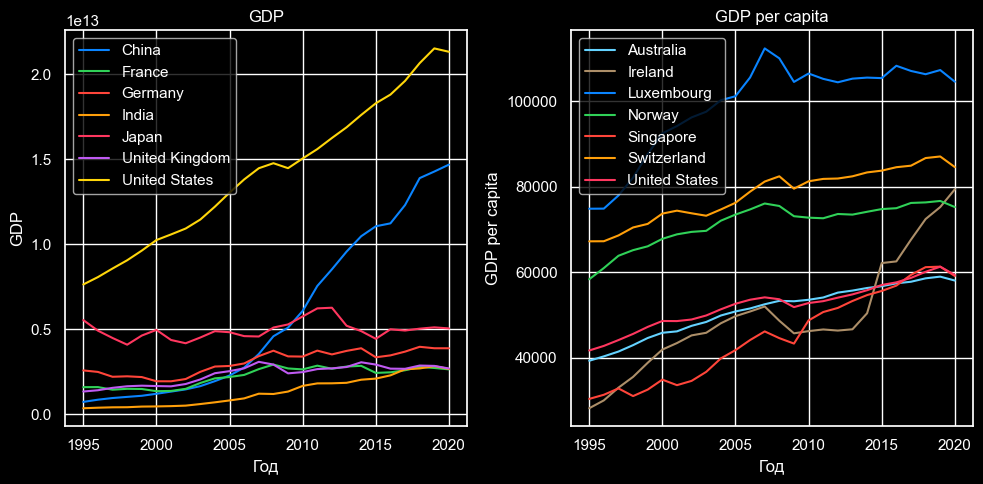

In [104]:
plt.figure("GDP", figsize=(10, 5))

attributes = ["GDP", "GDP per capita"]


for i in range(2):
    axis = plt.subplot(1, 2, i + 1)
    plt.title(attributes[i])
    for country, series in df[df["group"] == i + 1].groupby(["country"]):
        axis = series.plot(
            x="date",
            y=attributes[i],
            label=country[0],
            xlabel="Год",
            ylabel=attributes[i],
            ax=axis,
            color=next(color_gen)
        )

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/GDP 1.png", transparent=True)
plt.show()

### Показатели "наоброт" для других групп (для сравнения)

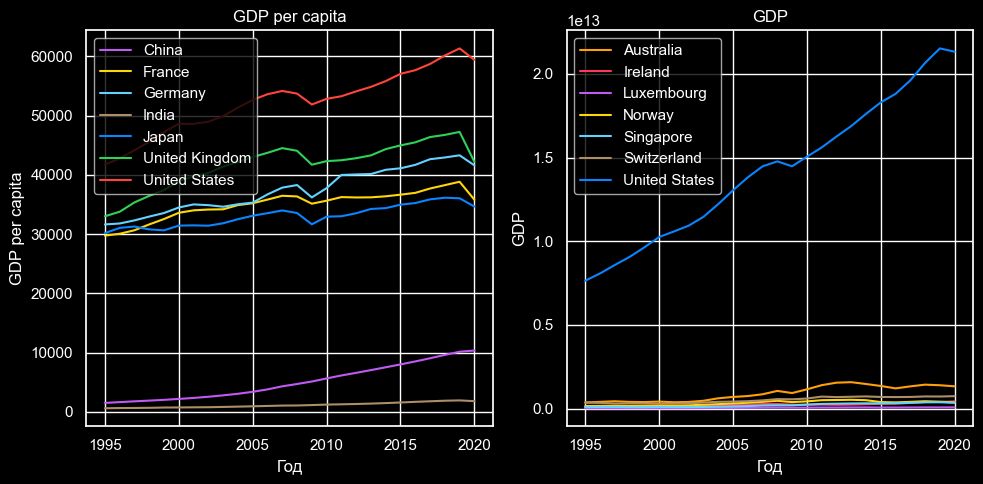

In [105]:
plt.figure("GDP", figsize=(10, 5))

attributes = ["GDP per capita", "GDP"]


for i in range(2):
    axis = plt.subplot(1, 2, i + 1)
    plt.title(attributes[i])
    for country, series in df[df["group"] == i + 1].groupby(["country"]):
        axis = series.plot(
            x="date",
            y=attributes[i],
            label=country[0],
            xlabel="Год",
            ylabel=attributes[i],
            ax=axis,
            color=next(color_gen)
        )

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/GDP 2.png", transparent=True)
plt.show()

# Экономика
### Инфляция и безработица

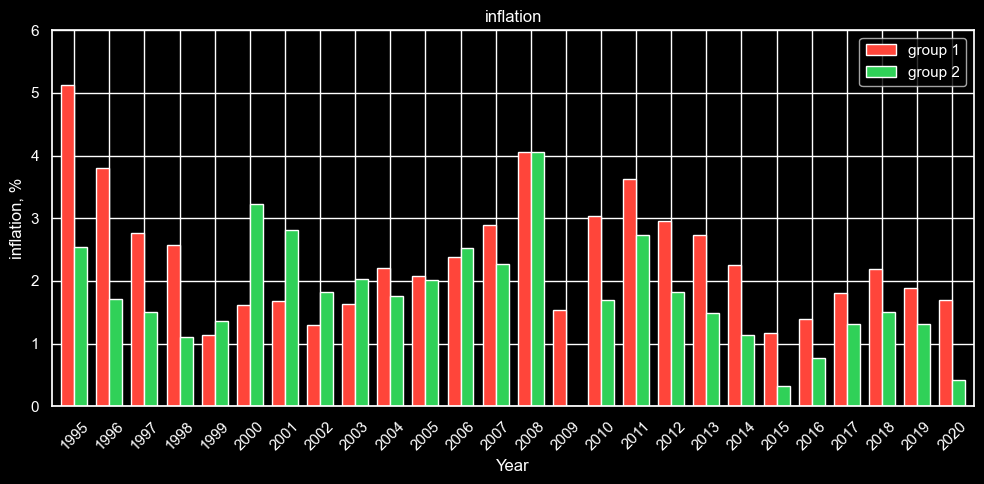

In [106]:
fig = plt.figure("Inflation", figsize=(10, 5))

attribute = "inflation"


axis = plt.subplot()
plt.title(attribute)

means = (
    df.groupby(["date", "group"])
    .aggregate({attribute: "mean"})
    .unstack(level=1)
)
axis = means.plot(
    kind="bar",
    ylabel=attribute + ", %",
    rot=45,
    xlabel="Year",
    ax=axis,
    color=[my_colors['red'], my_colors['green']],
    width=0.74,
)
axis.set_ylim(0, 6)
plt.legend(labels=["group 1", "group 2"])

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/inflation.png", transparent=True)
plt.show()

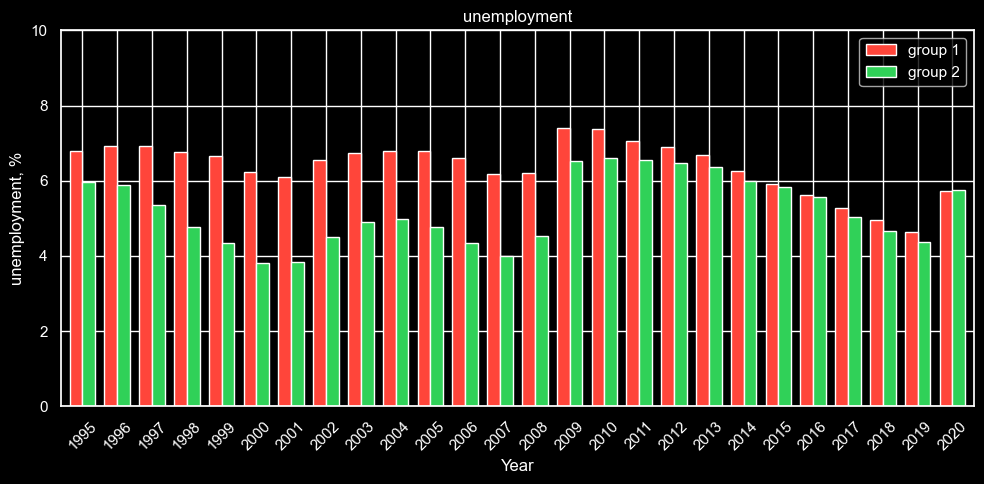

In [107]:
fig = plt.figure("Unemployment", figsize=(10, 5))

attribute = "unemployment"


axis = plt.subplot()
plt.title(attribute)

means = (
    df.groupby(["date", "group"])
    .aggregate({attribute: "mean"})
    .unstack(level=1)
)
axis = means.plot(
    kind="bar",
    ylabel=attribute + ", %",
    rot=45,
    xlabel="Year",
    ax=axis,
    color=[my_colors['red'], my_colors['green']],
    width=0.74,
)
axis.set_ylim(0, 10)
plt.legend(labels=["group 1", "group 2"])

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/unemployment.png", transparent=True)
plt.show()

### Выводы об инфляции и безработице


## Состав экспорта

In [108]:
for i in ["goods imports", 'services imports']:
    df[i] = df[i] / df['total imports'] * 100
for i in ["goods exports", 'services exports']:
    df[i] = df[i] / df['total exports'] * 100

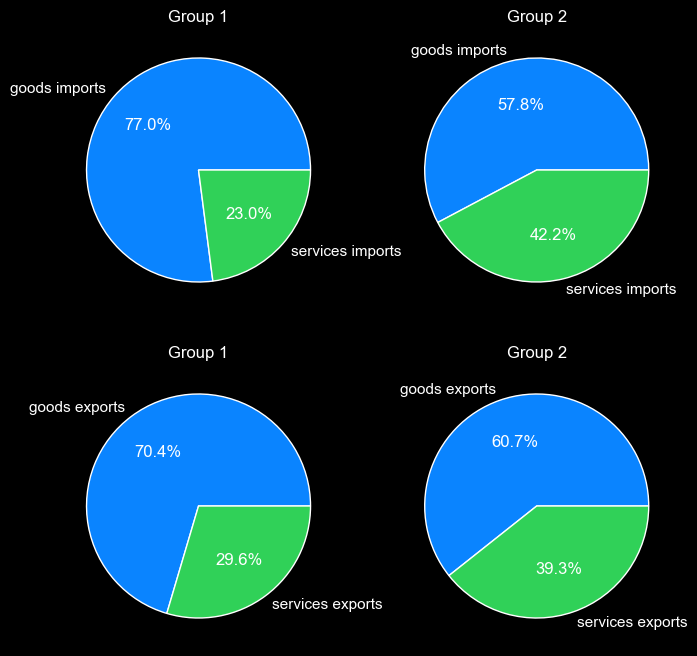

In [109]:
attributes = [
    ["goods imports", "services imports"], # imports
    ["goods exports", "services exports"], # exports
]

n_last_years = 1

figure = plt.figure("Imports and exports", figsize=(8, 8))

for i in range(2):
    pie_df = (
        df[df["date"] > end_year - n_last_years]
        .groupby(["group"])
        .aggregate({attr: "mean" for attr in attributes[i]})
        .reset_index()
        .transpose()
    )

    for j in range(2):
        axis = plt.subplot(2, 2, i * 2 + j + 1)
        axis.set_title(f'Group {j + 1}')
        axis.pie(
            x=pie_df[j].drop(index="group"),
            autopct="%1.1f%%",
            labels=pie_df.drop(index="group").index,
            colors=[my_colors['blue'], my_colors['green']]
    )

if save_plots_to_file:
    plt.savefig("pics/imports-and-exports.png", transparent=True)
plt.show()

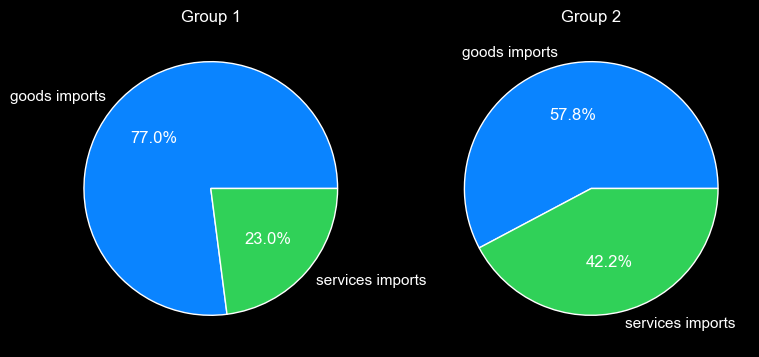

In [110]:
attributes = ["goods imports", "services imports"]

figure = plt.figure("Imports", figsize=(9, 5))

pie_df = (
    df[df["date"] == end_year]
    .groupby(["group"])
    .aggregate({attr: "mean" for attr in attributes})
    .reset_index()
    .transpose()
)

for j in range(2):
    axis = plt.subplot(1, 2, j + 1)
    axis.set_title(f'Group {j + 1}')
    axis.pie(
        x=pie_df[j].drop(index="group"),
        autopct="%1.1f%%",
        labels=pie_df.drop(index="group").index,
        colors=[my_colors['blue'], my_colors['green']]
)

if save_plots_to_file:
    plt.savefig("pics/imports.png", transparent=True)
plt.show()

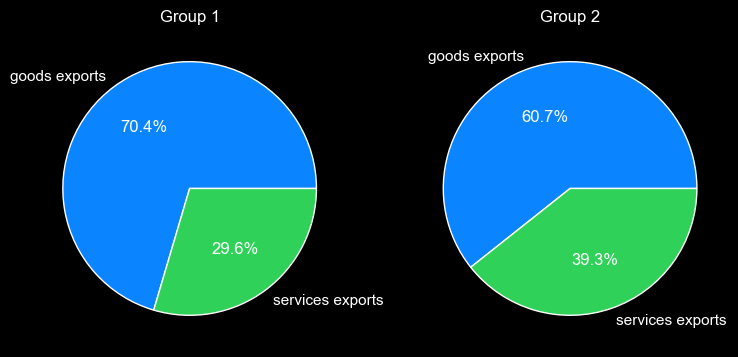

In [111]:
attributes = ["goods exports", "services exports"]

figure = plt.figure("Exports", figsize=(9, 5))

pie_df = (
    df[df["date"] == end_year]
    .groupby(["group"])
    .aggregate({attr: "mean" for attr in attributes})
    .reset_index()
    .transpose()
)

for j in range(2):
    axis = plt.subplot(1, 2, j + 1)
    axis.set_title(f'Group {j + 1}')
    axis.pie(
        x=pie_df[j].drop(index="group"),
        autopct="%1.1f%%",
        labels=pie_df.drop(index="group").index,
        colors=[my_colors['blue'], my_colors['green']]
)

if save_plots_to_file:
    plt.savefig("pics/exports.png", transparent=True)
plt.show()

### Портреты стран разных групп

# Сравнение показателей, определяющих уровень жизни

## Численность населения

In [112]:
# data for presentation
df[df["date"] == end_year][["country", "group", "population"]].sort_values(
    ["group", "population"], ascending=[True, False]
)

,country,group,population
4851,China,1,1.411100e+09
7388,India,1,1.396387e+09
13471,United States,1,3.315269e+08
7918,Japan,1,1.262610e+08
6528,Germany,1,8.316087e+07
6247,France,1,6.757111e+07
13407,United Kingdom,1,6.708123e+07
13471,United States,2,3.315269e+08
3228,Australia,2,2.564925e+07
12513,Switzerland,2,8.638167e+06


## Средний годовой доход

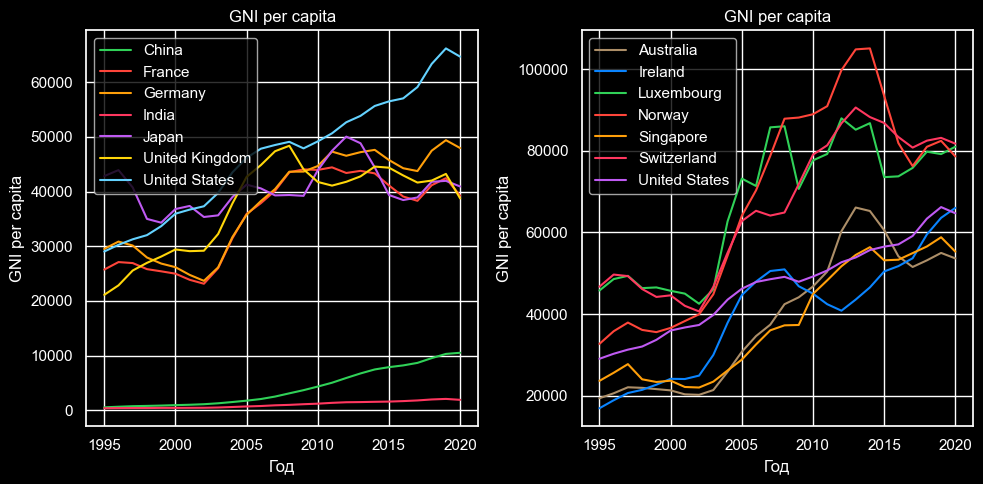

In [113]:
plt.figure("GNI", figsize=(10, 5))

attribute = "GNI per capita"

for i in range(2):
    axis = plt.subplot(1, 2, i + 1)
    plt.title(attribute)
    for country, series in df[df["group"] == i + 1].groupby(["country"]):
        axis = series.plot(
            x="date",
            y=attribute,
            label=country[0],
            xlabel="Год",
            ylabel=attribute,
            ax=axis,
            color=next(color_gen),
        )

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/GNI.png", transparent=True)
plt.show()

На этих графиках заметна динамика во времени, теперь сравнение между собой

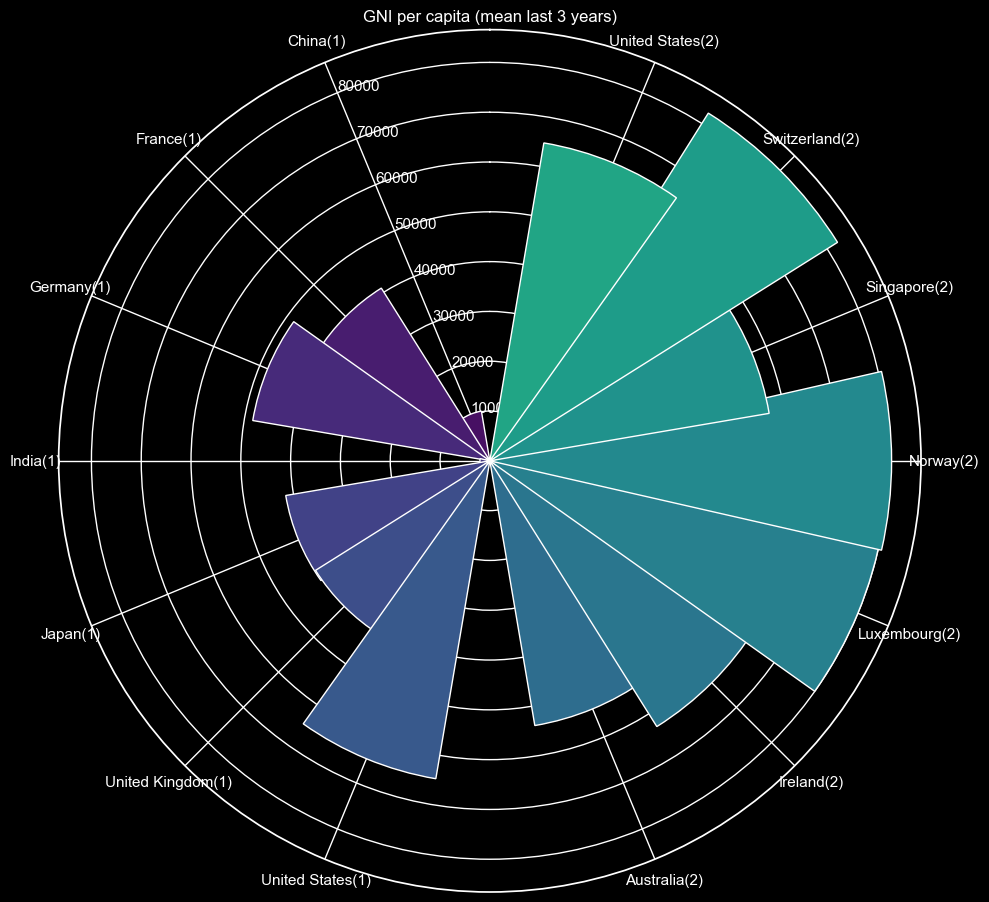

In [114]:
plt.figure("GNI", figsize=(10, 10))

attribute = "GNI per capita"

axis = plt.subplot(projection='polar')
#axis = plt.subplot()


n_last_years = 3

means = (
    df[df["date"] > end_year - n_last_years]
    .groupby(["country", 'group'])
    .aggregate({attribute: "mean"})
    .reset_index()
    .sort_values(['group', 'country'])
)


n = len(means)
step = 2 * np.pi / (n + 2)
angles = np.arange(step, np.pi, step)
angles = np.concatenate([angles, angles + np.pi])
means['angles'] = angles
means['labels'] = means['country'] + '(' + means['group'].map(str) + ')'

axis.bar(
    x=means['angles'],
    width=2*np.pi/n,
    height=means['GNI per capita'],
    tick_label=means['labels'],
    color=plt.cm.viridis(angles / 10.),
)
axis.set_theta_offset(np.pi/2)
plt.title(f'GNI per capita (mean last {n_last_years} years)')

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/GNI-round.png", transparent=True)
plt.show()

## Рождаемость и смертность

In [115]:
# отрицание значений, чтобы правильно отобразить на графике
df["death rate"] = -df["death rate"]

Mean birth rate in 1 group: 10.441714285714285
Mean birth rate in 2 group: 10.285714285714286
Mean death rate in 1 group: 9.67
Mean death rate in 2 group: 7.409999999999999


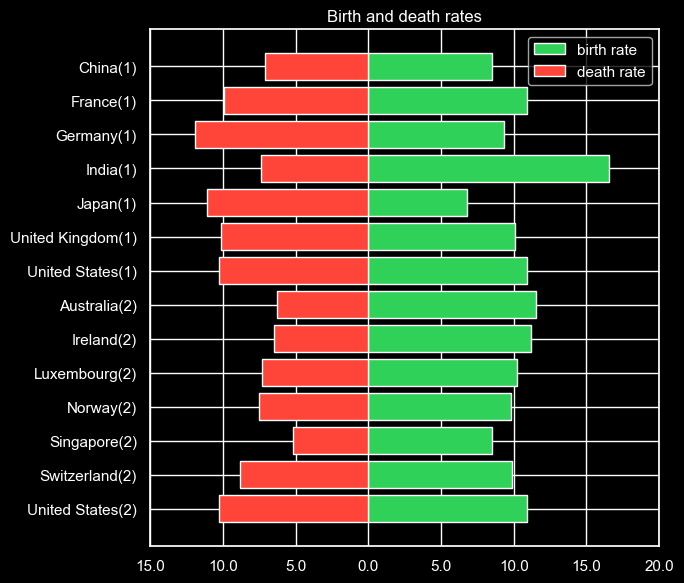

In [116]:
### Рождаемость и смертность
attributes = ["birth rate", "death rate"]

figure = plt.figure("Life expectancy", figsize=(7, 6))

axis = plt.subplot()

for i in range(2):
    data = (
        df[df["date"] == end_year][["country", "group", attributes[i]]]
        .sort_values(["group", "country"], ascending=False)
        .reset_index(drop=True)
    )
    data["labels"] = data["country"] + "(" + data["group"].map(str) + ")"
    for j in range(2):
        print(
            f"Mean {attributes[i]} in {j + 1} group:",
            abs(data[data["group"] == j + 1][attributes[i]].mean()),
        )
    axis.barh(
        y=data["labels"],
        width=data[attributes[i]],
        color=[my_colors['green'], my_colors['red']][i]
    )

plt.legend(labels=attributes)
plt.xticks(ticks=plt.xticks()[0], labels=map(lambda x: str(abs(x)), plt.xticks()[0]))
plt.title("Birth and death rates")
plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/birth-and-death-rates.png", transparent=True)
plt.show()

## Ожидаемая продолжительность жизни

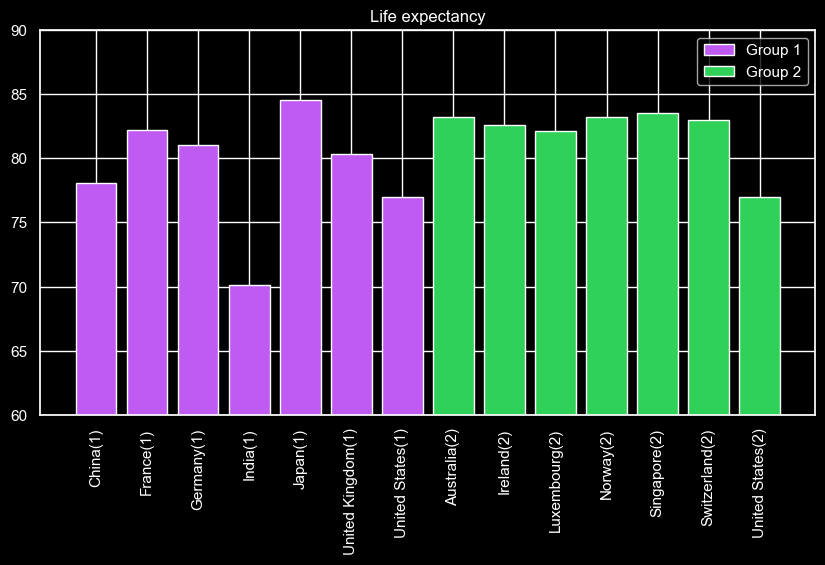

In [117]:
figure = plt.figure("Life expectancy", figsize=(10, 5))

axis = plt.subplot()

data = df[df["date"] == end_year][["country", "group", "life expectancy"]].sort_values(
    ["group", "country"]
).reset_index(drop=True)
data["labels"] = data["country"] + "(" + data["group"].map(str) + ")"
n = len(data)

axis.bar(
    x=data['labels'],
    height=data[data['group'] == 1]['life expectancy'].to_list() + [0] * (n // 2),
    color=my_colors['purple']
)
axis.bar(
    x=data['labels'],
    height=[0] * (n // 2) + data[data['group'] == 2]['life expectancy'].to_list(),
    color=my_colors['green'],
)
plt.xticks(rotation=90)
plt.ylim(60, 90)
plt.legend(labels=['Group 1', 'Group 2'])
plt.title('Life expectancy')
if save_plots_to_file:
    plt.savefig("pics/life-expectancy.png", transparent=True)
plt.show()